In [21]:
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np
import torch.utils.data
import cv2
import torchvision.models.segmentation
import torch
import os
import glob
import random





In [2]:
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
batchSize=2
imageSize=[600,600]
imgs=[]

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')   # train on the GPU or on the CPU, if a GPU is not available
print(device)

#imagePath = r"/content/drive/MyDrive/Colab Notebooks/FibreAnalysis"
imagePath = r"C:\Users\dezos\Documents\Fibres\FibreAnalysis"

sample_images = os.path.join(imagePath, 'Data', 'Prepared', 'Train', 'images', '')
sample_masks = os.path.join(imagePath, 'Data', 'Prepared', 'Train', 'masks', '')

file_pattern = os.path.join(sample_images, "*.png")

# Use glob to retrieve all matching file paths
file_paths = glob.glob(file_pattern)
# Extract filenames without the path
imgs = [os.path.basename(file_path) for file_path in file_paths]


cpu


In [23]:
imgs

['image_2023-07-06_14-01-52-172651_1.png',
 'image_2023-07-06_14-01-52-342225_1.png',
 'image_2023-07-06_14-01-52-342225_2.png',
 'image_2023-07-06_14-01-52-558851_1.png',
 'image_2023-07-06_14-01-52-727192_1.png',
 'image_2023-07-06_14-01-52-897436_1.png',
 'image_2023-07-06_14-01-52-897436_2.png',
 'image_2023-07-06_14-01-58-848282_1.png',
 'image_2023-07-06_14-01-59-017473_1.png',
 'image_2023-07-06_14-01-59-017473_2.png',
 'image_2023-07-06_14-01-59-212638_1.png',
 'image_2023-07-06_14-01-59-212638_2.png',
 'image_2023-07-06_14-01-59-421827_1.png',
 'image_2023-07-06_14-01-59-586271_1.png',
 'image_2023-07-06_14-01-59-586271_2.png',
 'image_2023-07-06_14-02-05-068904_1.png',
 'image_2023-07-06_14-02-05-267200_1.png',
 'image_2023-07-06_14-02-05-451348_1.png',
 'image_2023-07-06_14-02-05-657530_1.png',
 'image_2023-07-06_14-02-05-834295_1.png',
 'image_2023-07-06_14-02-05-834295_2.png',
 'image_2023-07-06_14-02-10-743266_1.png',
 'image_2023-07-06_14-02-10-930816_1.png',
 'image_202

In [26]:
# taken from https://towardsdatascience.com/train-mask-rcnn-net-for-object-detection-in-60-lines-of-code-9b6bbff292c3

def loadData():
  batch_Imgs=[]
  batch_Data=[]
  for i in range(batchSize):
        idx=random.randint(0,len(imgs)-1)
        img = cv2.imread(os.path.join(sample_images , imgs[idx]))
        img = cv2.resize(img, imageSize, cv2.INTER_LINEAR)

        sample_masks = os.path.join(imagePath, 'Data', 'Prepared', 'Train', 'masks', '')
        masks=[]

        filename, extension = os.path.splitext(imgs[idx])
        maskFile =  "mask" + filename[5:] + extension

        vesMask = cv2.imread(os.path.join(sample_masks , maskFile), 0)

        vesMask = (vesMask > 0).astype(np.uint8)
        vesMask=cv2.resize(vesMask,imageSize,cv2.INTER_NEAREST)

        masks.append(vesMask)
        num_objs = len(masks)

        # will prob need cv2.findContours to split out all the masks into individual numbers. and then 
        # get bounding rect for each of those.
        
        if num_objs==0: return loadData() # legacy from the sample code that could have had multiple individual masks
        boxes = torch.zeros([num_objs,4], dtype=torch.float32)


        print('number of objects', num_objs)
        
        for i in range(num_objs):
            x,y,w,h = cv2.boundingRect(masks[i])
            boxes[i] = torch.tensor([x, y, x+w, y+h])

        masks = torch.as_tensor(masks, dtype=torch.uint8)

        #tempImg = img

        img = torch.as_tensor(img, dtype=torch.float32)
        data = {}
        data["boxes"] =  boxes
        data["labels"] =  torch.ones((num_objs,), dtype=torch.int64)
        data["masks"] = masks
        batch_Imgs.append(img)
        batch_Data.append(data)

        # Draw the bounding box on the image
        # cv2.rectangle(tempImg, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # # # Display the image
        # cv2.imshow("Image with Bounding Box", tempImg)

        # # # Wait for a key press and close the windows
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

  batch_Imgs=torch.stack([torch.as_tensor(d) for d in batch_Imgs],0)
  batch_Imgs = batch_Imgs.swapaxes(1, 3).swapaxes(2, 3)
  return batch_Imgs, batch_Data


In [27]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)  # load an instance segmentation model pre-trained pre-trained on COCO

## maybe use instead of pretrained --> weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT

in_features = model.roi_heads.box_predictor.cls_score.in_features  # get number of input features for the classifier
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes=2)  # replace the pre-trained head with a new one
model.to(device)# move model to the right devic


# have a look at https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
# at line model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, to see if I should retrain the mask head too

optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
model.train()

for i in range(10001):
            images, targets = loadData()
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.step()
            print(i,'loss:', losses.item())
            
            
            #################################################################
            # this next piece is from https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
            # maybe it could be included to check how reduction in learning rates affects the model performance
            
            # lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
            #                                    step_size=3,
            #                                    gamma=0.1)
            
            # # update the learning rate
            # lr_scheduler.step()
            
            #################################################################
            
            if i%500==0:
                torch.save(model.state_dict(), str(i)+".torch")

c:\Users\dezos\Documents\Fibres\FibreAnalysis\Fibres1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dezos\Documents\Fibres\FibreAnalysis\Fibres1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


number of objects 1
number of objects 1
0 loss: 116.48542785644531
number of objects 1
number of objects 1
1 loss: 125.26883697509766
number of objects 1
number of objects 1
2 loss: 22.192899703979492
number of objects 1
number of objects 1
3 loss: 9.970723152160645
number of objects 1
number of objects 1
4 loss: 9.450997352600098
number of objects 1
number of objects 1
5 loss: 16.2535457611084
number of objects 1
number of objects 1


KeyboardInterrupt: 

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes=2)
model.load_state_dict(torch.load("6500.torch"))
model.to(device)# move model to the right devic
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [43]:
# Get test image


test_images = os.path.join(imagePath, 'Data', 'synth', 'images', '')


actualTestImage = os.path.join(test_images, "image_2023-06-24_13-30-18-074380.png")

In [44]:
images = cv2.imread(actualTestImage)

images = cv2.resize(images, imageSize, cv2.INTER_LINEAR)
image1 = images
images = torch.as_tensor(images, dtype=torch.float32).unsqueeze(0)
images=images.swapaxes(1, 3).swapaxes(2, 3)
images = list(image.to(device) for image in images)
with torch.no_grad():
    pred = model(images)


In [45]:
pred

[{'boxes': tensor([[165.2341, 403.7852, 182.8505, 459.2506],
          [154.8251, 410.1931, 188.0271, 462.1101],
          [169.5946, 413.7952, 187.6641, 454.8602],
          [  0.0000, 599.9434,  41.7498, 600.0000],
          [134.2003, 412.9066, 192.9476, 470.5846],
          [159.2760, 427.6581, 183.8701, 456.3533],
          [149.1601, 407.4418, 223.7223, 464.2614]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9308, 0.5512, 0.4288, 0.2182, 0.0752, 0.0731, 0.0700],
         device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ..

In [62]:
mask = pred[0]['masks'][0]  # Get the mask corresponding to the highest score
print((mask>0).sum().item())


1180


In [ ]:
# cv2_imshow(image1)
# cv2.waitKey()

0.07001927


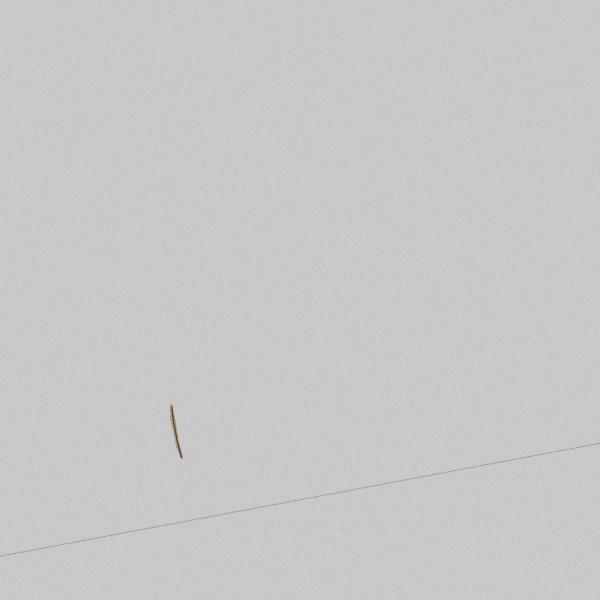

-1

In [47]:
im= images[0].swapaxes(0, 2).swapaxes(0, 1).detach().cpu().numpy().astype(np.uint8)

im2 = im.copy()

for i in range(len(pred[0]['masks'])):
    msk=pred[0]['masks'][i,0].detach().cpu().numpy()
    scr=pred[0]['scores'][i].detach().cpu().numpy()
    if scr>0.8 :
        im2[:,:,0][msk>0.5] = random.randint(0,255)
        im2[:, :, 1][msk > 0.5] = random.randint(0,255)
        im2[:, :, 2][msk > 0.5] = random.randint(0, 255)

print(str(scr))
#cv2_imshow(str(scr), np.hstack([im,im2]))
#cv2_imshow(np.hstack([im,im2]))

# Overlay the images
alpha = 0.5  # Weight for the first image (im)
beta = 0.5   # Weight for the second image (im2)
overlayed_image = cv2.addWeighted(im, alpha, im2, beta, 0.0)

# Display the overlayed image
cv2_imshow( overlayed_image)
cv2.waitKey()